In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import TruncatedSVD
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from google.colab import files
import joblib
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*100)
print("ADVANCED ML PIPELINE - KERNEL APPROXIMATION, XGBOOST, GRADIENT BOOSTING, RANDOM FOREST, LIGHTGBM")
print("="*100)


ADVANCED ML PIPELINE - KERNEL APPROXIMATION, XGBOOST, GRADIENT BOOSTING, RANDOM FOREST, LIGHTGBM


# # 1. Load Train, Validation, and Test Data


In [2]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

uploaded = files.upload()

# Load the split datasets
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('validation_data.csv')
test_data = pd.read_csv('test_data.csv')

print(f"✓ Training data loaded: {train_data.shape}")
print(f"✓ Validation data loaded: {val_data.shape}")
print(f"✓ Test data loaded: {test_data.shape}")

print("\nTraining data preview:")
print(train_data.head())

print("\nData info:")
print(train_data.info())



LOADING DATA


Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving validation_data.csv to validation_data.csv
✓ Training data loaded: (350000, 12)
✓ Validation data loaded: (49995, 12)
✓ Test data loaded: (100005, 12)

Training data preview:
                    timestamp       source_ip      server  username service  \
0  2023-03-10 12:15:52.854311   42.43.209.134   db-ber-01    ubuntu    cron   
1  2023-03-10 21:22:09.618009   148.119.14.98  srv-ldn-02    ubuntu   login   
2  2023-03-07 10:26:04.033772  32.117.236.204   db-ber-01     nginx   login   
3  2023-01-01 03:34:27.508909  131.94.192.211  srv-ldn-02    ubuntu    sudo   
4  2023-01-01 07:40:26.555102   50.94.188.249  web-sgp-02  www-data     ssh   

   attempts   status  port protocol                    comment  \
0         1   Failed  22.0     SSH2          User ubuntu login   
1         1   Failed  22.0     SSH2          User ubuntu login   
2         1   Failed  22.0     SSH2           User nginx login   
3

# # 2. Advanced Feature Engineering


In [3]:
print("\n" + "="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

def advanced_feature_engineering(df):
    """
    Apply advanced feature engineering
    Focus on: Aggregations, Interactions, Statistical features
    (NO encoding here – encoding is handled later in the pipeline)
    """
    df_engineered = df.copy()

    # Convert timestamp to datetime
    if 'timestamp' in df_engineered.columns:
        df_engineered['timestamp'] = pd.to_datetime(df_engineered['timestamp'])

        # Time-based features
        df_engineered['hour'] = df_engineered['timestamp'].dt.hour
        df_engineered['day_of_week'] = df_engineered['timestamp'].dt.dayofweek

        df_engineered['is_business_hours'] = (
            (df_engineered['hour'] >= 9) & (df_engineered['hour'] <= 17)
        ).astype(int)

        df_engineered['is_midnight_to_6am'] = (
            (df_engineered['hour'] >= 0) & (df_engineered['hour'] <= 6)
        ).astype(int)

        df_engineered['hour_sin'] = np.sin(2 * np.pi * df_engineered['hour'] / 24)
        df_engineered['hour_cos'] = np.cos(2 * np.pi * df_engineered['hour'] / 24)
        df_engineered['day_sin'] = np.sin(2 * np.pi * df_engineered['day_of_week'] / 7)
        df_engineered['day_cos'] = np.cos(2 * np.pi * df_engineered['day_of_week'] / 7)

        # Drop original timestamp
        df_engineered = df_engineered.drop('timestamp', axis=1)

    # Convert status to numeric
    if 'status' in df_engineered.columns:
        df_engineered['status'] = df_engineered['status'].map({
            'Success': 1,
            'Failed': 0
        })

    # Feature interactions
    if 'attempts' in df_engineered.columns and 'port' in df_engineered.columns:
        df_engineered['attempts_x_port'] = df_engineered['attempts'] * df_engineered['port']
        df_engineered['attempts_squared'] = df_engineered['attempts'] ** 2
        df_engineered['port_log'] = np.log1p(df_engineered['port'])

    # Statistical features for attempts
    if 'attempts' in df_engineered.columns:
        df_engineered['attempts_high'] = (df_engineered['attempts'] > 3).astype(int)
        df_engineered['attempts_very_high'] = (df_engineered['attempts'] > 5).astype(int)

    # Port categorization
    if 'port' in df_engineered.columns:
        df_engineered['is_common_port'] = df_engineered['port'].isin(
            [22, 80, 443, 3389]
        ).astype(int)
        df_engineered['is_ssh_port'] = (df_engineered['port'] == 22).astype(int)
        df_engineered['is_http_port'] = df_engineered['port'].isin([80, 443]).astype(int)

    # Remove high-cardinality / noisy features
    if 'source_ip' in df_engineered.columns:
        df_engineered = df_engineered.drop('source_ip', axis=1)

    if 'comment' in df_engineered.columns:
        df_engineered = df_engineered.drop('comment', axis=1)

    return df_engineered


# Apply advanced feature engineering
print("Applying advanced feature engineering...")
train_engineered = advanced_feature_engineering(train_data)
val_engineered   = advanced_feature_engineering(val_data)
test_engineered  = advanced_feature_engineering(test_data)

print(f"\n✓ Training data after engineering: {train_engineered.shape}")
print(f"✓ Validation data after engineering: {val_engineered.shape}")
print(f"✓ Test data after engineering: {test_engineered.shape}")

print("\nNew engineered features:")
new_features = [
    col for col in train_engineered.columns
    if col not in train_data.columns or col == 'anomaly_label'
]
print(new_features)



ADVANCED FEATURE ENGINEERING
Applying advanced feature engineering...

✓ Training data after engineering: (350000, 25)
✓ Validation data after engineering: (49995, 25)
✓ Test data after engineering: (100005, 25)

New engineered features:
['anomaly_label', 'hour', 'day_of_week', 'is_business_hours', 'is_midnight_to_6am', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'attempts_x_port', 'attempts_squared', 'port_log', 'attempts_high', 'attempts_very_high', 'is_common_port', 'is_ssh_port', 'is_http_port']


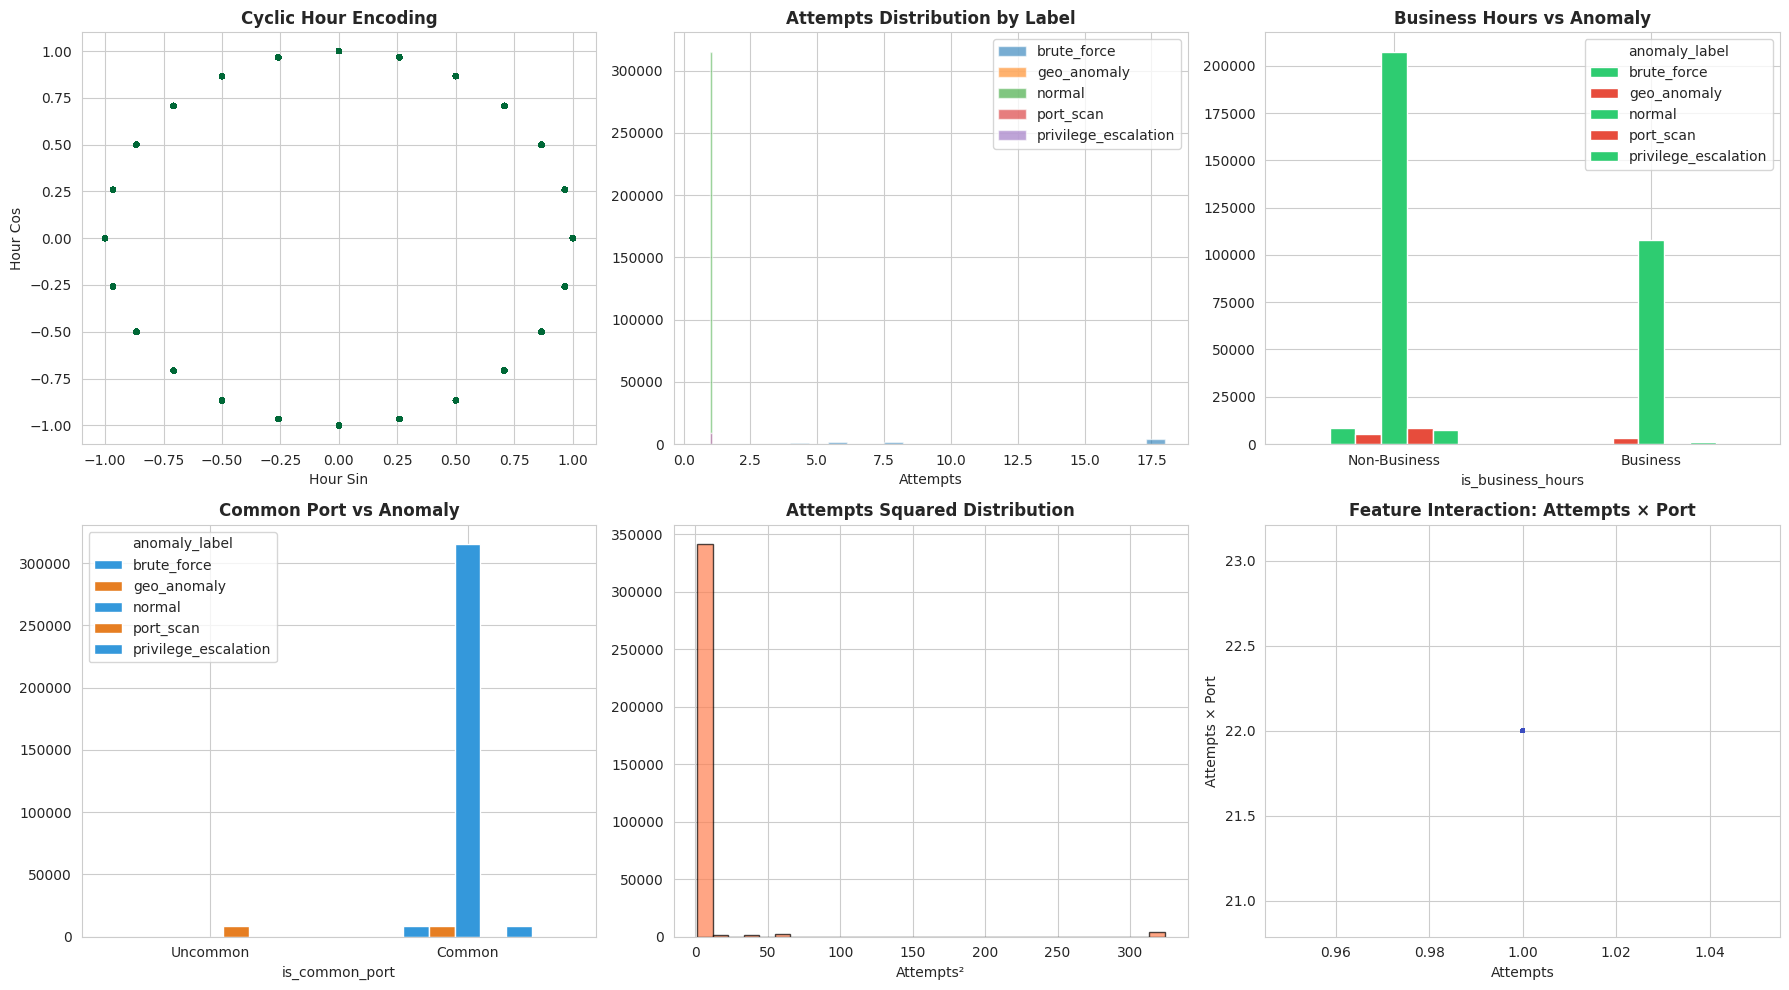

In [4]:
# Visualize new features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Hour sin/cos
if 'hour_sin' in train_engineered.columns:
    axes[0, 0].scatter(train_engineered['hour_sin'], train_engineered['hour_cos'],
                       c=train_engineered['anomaly_label'].map({'normal': 0, 'anomaly': 1}),
                       cmap='RdYlGn_r', alpha=0.5, s=10)
    axes[0, 0].set_title('Cyclic Hour Encoding', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Hour Sin')
    axes[0, 0].set_ylabel('Hour Cos')

# Plot 2: Attempts distribution
if 'attempts' in train_engineered.columns:
    train_engineered.groupby('anomaly_label')['attempts'].hist(ax=axes[0, 1], alpha=0.6, bins=20, legend=True)
    axes[0, 1].set_title('Attempts Distribution by Label', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Attempts')

# Plot 3: Business hours vs anomaly
if 'is_business_hours' in train_engineered.columns:
    pd.crosstab(train_engineered['is_business_hours'], train_engineered['anomaly_label']).plot(
        kind='bar', ax=axes[0, 2], color=['#2ecc71', '#e74c3c'])
    axes[0, 2].set_title('Business Hours vs Anomaly', fontsize=12, fontweight='bold')
    axes[0, 2].set_xticklabels(['Non-Business', 'Business'], rotation=0)

# Plot 4: Common port vs anomaly
if 'is_common_port' in train_engineered.columns:
    pd.crosstab(train_engineered['is_common_port'], train_engineered['anomaly_label']).plot(
        kind='bar', ax=axes[1, 0], color=['#3498db', '#e67e22'])
    axes[1, 0].set_title('Common Port vs Anomaly', fontsize=12, fontweight='bold')
    axes[1, 0].set_xticklabels(['Uncommon', 'Common'], rotation=0)

# Plot 5: Attempts squared distribution
if 'attempts_squared' in train_engineered.columns:
    axes[1, 1].hist(train_engineered['attempts_squared'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Attempts Squared Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Attempts²')

# Plot 6: Feature interaction
if 'attempts_x_port' in train_engineered.columns:
    axes[1, 2].scatter(train_engineered['attempts'], train_engineered['attempts_x_port'],
                       c=train_engineered['anomaly_label'].map({'normal': 0, 'anomaly': 1}),
                       cmap='coolwarm', alpha=0.3, s=5)
    axes[1, 2].set_title('Feature Interaction: Attempts × Port', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Attempts')
    axes[1, 2].set_ylabel('Attempts × Port')

plt.tight_layout()
plt.show()


In [5]:
# Separate features and target
print("\n" + "="*80)
print("SEPARATING FEATURES AND TARGET")
print("="*80)

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_train = le_target.fit_transform(train_engineered['anomaly_label'])
y_val = le_target.transform(val_engineered['anomaly_label'])
y_test = le_target.transform(test_engineered['anomaly_label'])

# Drop target from features
X_train = train_engineered.drop('anomaly_label', axis=1)
X_val = val_engineered.drop('anomaly_label', axis=1)
X_test = test_engineered.drop('anomaly_label', axis=1)

print(f"✓ X_train shape: {X_train.shape}")
print(f"✓ X_val shape: {X_val.shape}")
print(f"✓ X_test shape: {X_test.shape}")
print(f"\nTarget classes: {le_target.classes_}")
print(f"Train class distribution: {np.bincount(y_train)}")



SEPARATING FEATURES AND TARGET
✓ X_train shape: (350000, 24)
✓ X_val shape: (49995, 24)
✓ X_test shape: (100005, 24)

Target classes: ['brute_force' 'geo_anomaly' 'normal' 'port_scan' 'privilege_escalation']
Train class distribution: [  8750   8750 315000   8750   8750]


# # 3. Feature Scaling with RobustScaler


In [10]:
print("\n" + "="*80)
print("FEATURE SCALING - ROBUST SCALER")
print("="*80)

# Select only numerical columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# Initialize RobustScaler
scaler = RobustScaler()

# Create copies of the datasets
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

# Scale ONLY numerical columns
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

print("✓ Features scaled using RobustScaler (only numerical columns)")
print(f"✓ Scaled train data shape: {X_train_scaled.shape}")

# Save the scaler
joblib.dump(scaler, "robust_scaler.pkl")
print("✓ Scaler saved as 'robust_scaler.pkl'")



FEATURE SCALING - ROBUST SCALER
✓ Features scaled using RobustScaler (only numerical columns)
✓ Scaled train data shape: (350000, 24)
✓ Scaler saved as 'robust_scaler.pkl'


# # 4. Feature Selection with RFE


In [11]:
print("\n" + "="*80)
print("FEATURE SELECTION - RECURSIVE FEATURE ELIMINATION (RFE)")
print("="*80)

# Select ONLY numerical columns
num_cols = X_train_scaled.select_dtypes(include=["int64", "float64"]).columns

estimator = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

# Determine the number of features to select
# At least 15 features, or 70% of numerical features
n_features_to_select = max(15, int(0.7 * len(num_cols)))

selector = RFE(
    estimator=estimator,
    n_features_to_select=n_features_to_select,
    step=1
)

# Fit RFE on training data and transform datasets
X_train_selected = selector.fit_transform(X_train_scaled[num_cols], y_train)
X_val_selected   = selector.transform(X_val_scaled[num_cols])
X_test_selected  = selector.transform(X_test_scaled[num_cols])

print("✓ RFE with Logistic Regression")
print(f"✓ Original numeric features: {len(num_cols)}")
print(f"✓ Selected features: {X_train_selected.shape[1]}")

# Get the names of selected features
selected_features = num_cols[selector.support_].tolist()
print(f"\nSelected features ({len(selected_features)}):")

for i, feat in enumerate(selected_features[:10], 1):
    print(f"  {i}. {feat}")

if len(selected_features) > 10:
    print(f"  ... and {len(selected_features) - 10} more")

# Save the trained feature selector
joblib.dump(selector, 'rfe_selector.pkl')
print("\n✓ Feature selector saved as 'rfe_selector.pkl'")



FEATURE SELECTION - RECURSIVE FEATURE ELIMINATION (RFE)
✓ RFE with Logistic Regression
✓ Original numeric features: 18
✓ Selected features: 15

Selected features (15):
  1. attempts
  2. status
  3. port
  4. delta_t
  5. is_business_hours
  6. is_midnight_to_6am
  7. hour_sin
  8. hour_cos
  9. day_sin
  10. day_cos
  ... and 5 more

✓ Feature selector saved as 'rfe_selector.pkl'


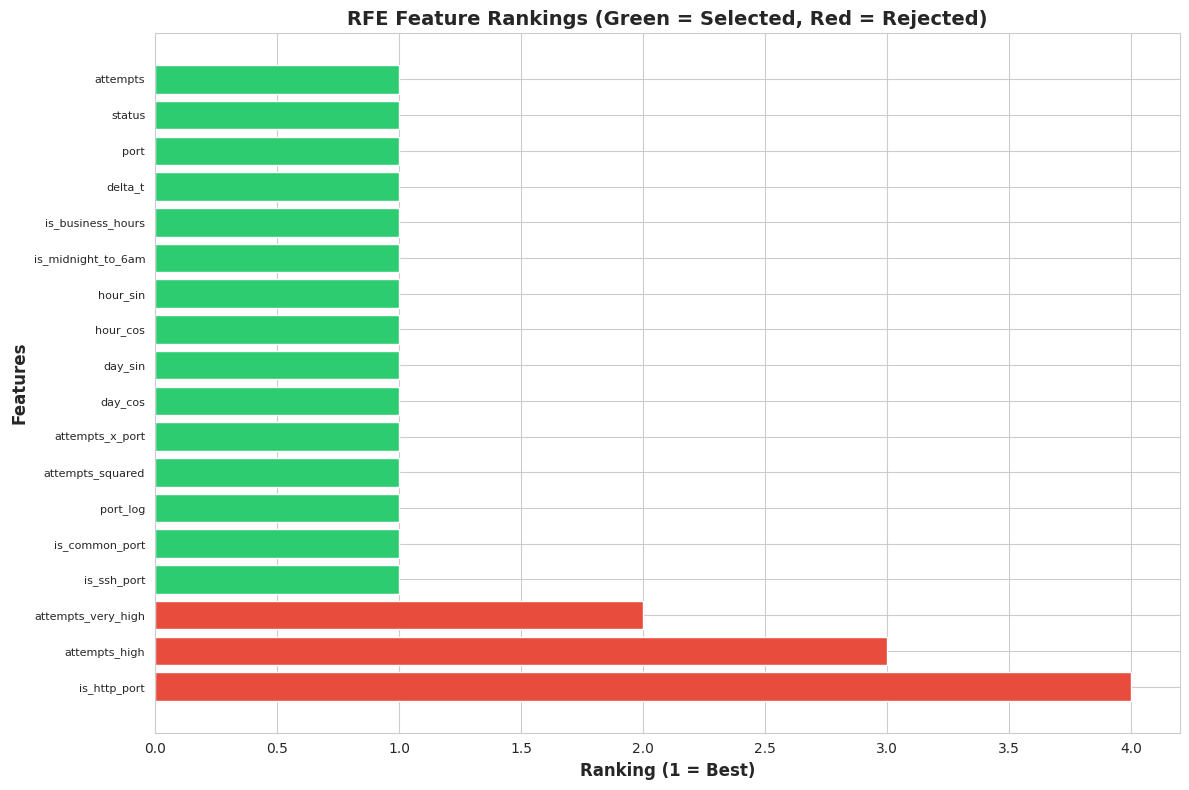

In [12]:
# Visualize feature rankings (ONLY numerical columns)

feature_ranking = pd.DataFrame({
    'Feature': num_cols,
    'Ranking': selector.ranking_,
    'Selected': selector.support_
}).sort_values('Ranking')

plt.figure(figsize=(12, 8))
colors = ['#2ecc71' if selected else '#e74c3c' for selected in feature_ranking['Selected']]
plt.barh(range(len(feature_ranking)), feature_ranking['Ranking'], color=colors)
plt.yticks(range(len(feature_ranking)), feature_ranking['Feature'], fontsize=8)
plt.xlabel('Ranking (1 = Best)', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('RFE Feature Rankings (Green = Selected, Red = Rejected)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# # 5. Dimensionality Reduction with TruncatedSVD


In [13]:
print("\n" + "="*80)
print("DIMENSIONALITY REDUCTION - TRUNCATED SVD")
print("="*80)

# TruncatedSVD is similar to PCA but works with sparse matrices
# Better for large datasets and doesn't center the data
n_components = min(12, X_train_selected.shape[1] - 1)  # Fixed number of components

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_selected)
X_val_svd = svd.transform(X_val_selected)
X_test_svd = svd.transform(X_test_selected)

variance_explained = svd.explained_variance_ratio_.sum()

print(f"✓ TruncatedSVD applied")
print(f"✓ Original features: {X_train_selected.shape[1]}")
print(f"✓ SVD components: {n_components}")
print(f"✓ Variance explained: {variance_explained:.4f}")
print(f"✓ Final train shape: {X_train_svd.shape}")

# Save SVD
joblib.dump(svd, 'truncated_svd.pkl')
print("✓ SVD model saved as 'truncated_svd.pkl'")



DIMENSIONALITY REDUCTION - TRUNCATED SVD
✓ TruncatedSVD applied
✓ Original features: 15
✓ SVD components: 12
✓ Variance explained: 1.0000
✓ Final train shape: (350000, 12)
✓ SVD model saved as 'truncated_svd.pkl'


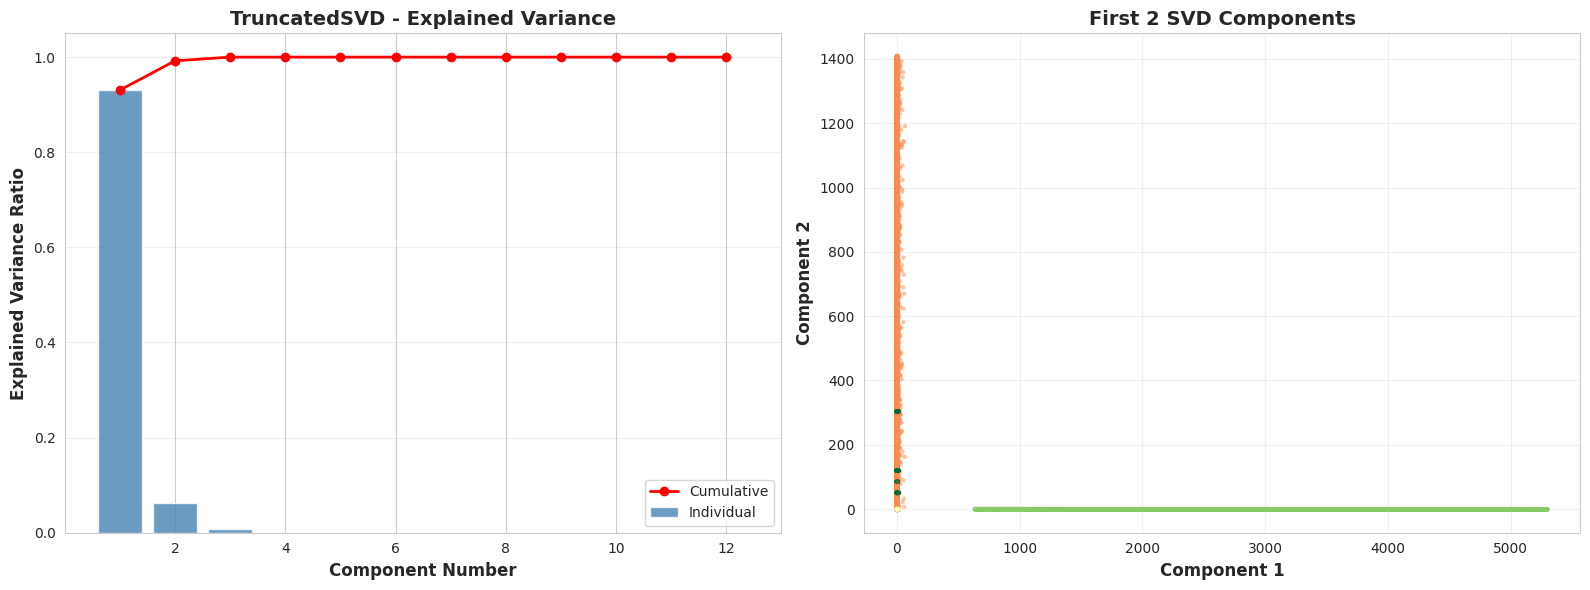

In [14]:
# Visualize SVD components
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Explained variance
axes[0].bar(range(1, len(svd.explained_variance_ratio_) + 1),
            svd.explained_variance_ratio_, color='steelblue', alpha=0.8)
axes[0].plot(range(1, len(svd.explained_variance_ratio_) + 1),
             np.cumsum(svd.explained_variance_ratio_), 'ro-', linewidth=2, markersize=6)
axes[0].set_xlabel('Component Number', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('TruncatedSVD - Explained Variance', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(['Cumulative', 'Individual'])

# Plot 2: First 2 components scatter
axes[1].scatter(X_train_svd[:, 0], X_train_svd[:, 1],
               c=y_train, cmap='RdYlGn_r', alpha=0.5, s=10, edgecolors='none')
axes[1].set_xlabel('Component 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Component 2', fontsize=12, fontweight='bold')
axes[1].set_title('First 2 SVD Components', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# # 6. Kernel Approximation


In [15]:
print("\n" + "="*80)
print("KERNEL APPROXIMATION - RBF SAMPLER")
print("="*80)

# RBFSampler approximates RBF kernel feature map
# Allows linear models to approximate non-linear kernels
n_components_kernel = 100
rbf_sampler = RBFSampler(n_components=n_components_kernel, gamma=1.0, random_state=42)

X_train_kernel = rbf_sampler.fit_transform(X_train_svd)
X_val_kernel = rbf_sampler.transform(X_val_svd)
X_test_kernel = rbf_sampler.transform(X_test_svd)

print(f"✓ RBF Kernel Approximation applied")
print(f"✓ Input features: {X_train_svd.shape[1]}")
print(f"✓ Kernel features: {n_components_kernel}")
print(f"✓ Output shape: {X_train_kernel.shape}")
print(f"✓ This allows linear models to capture non-linear patterns!")

# Save RBF Sampler
joblib.dump(rbf_sampler, 'rbf_sampler.pkl')
print("✓ RBF Sampler saved as 'rbf_sampler.pkl'")



KERNEL APPROXIMATION - RBF SAMPLER
✓ RBF Kernel Approximation applied
✓ Input features: 12
✓ Kernel features: 100
✓ Output shape: (350000, 100)
✓ This allows linear models to capture non-linear patterns!
✓ RBF Sampler saved as 'rbf_sampler.pkl'


# # 7. Model Training and Validation


In [16]:
from xgboost import XGBClassifier

print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

# Define models with kernel approximation support
models = {
    'Kernel Approximation (RBF + LogisticReg)': LogisticRegression(
        max_iter=1000, C=1.0, random_state=42, class_weight='balanced'
    ),
    'XGBoost Classifier': XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='mlogloss'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5,
        random_state=42, subsample=0.8
    ),
    'Random Forest Classifier': RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'LightGBM Classifier': LGBMClassifier(
        n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=42, n_jobs=-1
    )
}

# Store results
training_results = {}
validation_results = {}
trained_models = {}

print("\nTraining models on training data and validating on validation data...\n")

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)

    # Use kernel features for Kernel Approximation, SVD features for others
    if 'Kernel Approximation' in model_name:
        X_tr, X_v, X_te = X_train_kernel, X_val_kernel, X_test_kernel
        print("Using: RBF Kernel Features")
    else:
        X_tr, X_v, X_te = X_train_svd, X_val_svd, X_test_svd
        print("Using: SVD Features")

    # Train the model
    model.fit(X_tr, y_train)
    print(f"✓ {model_name} training completed")

    # Predictions on training set
    y_train_pred = model.predict(X_tr)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

    # Predictions on validation set
    y_val_pred = model.predict(X_v)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

    # Store results
    training_results[model_name] = {
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1_score': train_f1
    }

    validation_results[model_name] = {
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1
    }

    trained_models[model_name] = {
        'model': model,
        'data_type': 'kernel' if 'Kernel Approximation' in model_name else 'svd'
    }

    # Print results
    print(f"\nTraining Set Performance:")
    print(f"  Accuracy:  {train_accuracy:.4f}")
    print(f"  Precision: {train_precision:.4f}")
    print(f"  Recall:    {train_recall:.4f}")
    print(f"  F1-Score:  {train_f1:.4f}")

    print(f"\nValidation Set Performance:")
    print(f"  Accuracy:  {val_accuracy:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall:    {val_recall:.4f}")
    print(f"  F1-Score:  {val_f1:.4f}")

    # Check for overfitting
    overfit_score = train_accuracy - val_accuracy
    print(f"\nOverfitting Check: {overfit_score:.4f} (Train - Val Accuracy)")
    if overfit_score > 0.1:
        print("  Warning: Potential overfitting detected")
    else:

        print("  ✓ Model generalizes well")

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*80)



MODEL TRAINING

Training models on training data and validating on validation data...


Training: Kernel Approximation (RBF + LogisticReg)
Using: RBF Kernel Features
✓ Kernel Approximation (RBF + LogisticReg) training completed

Training Set Performance:
  Accuracy:  0.8483
  Precision: 0.9354
  Recall:    0.8483
  F1-Score:  0.8807

Validation Set Performance:
  Accuracy:  0.8472
  Precision: 0.9352
  Recall:    0.8472
  F1-Score:  0.8797

Overfitting Check: 0.0011 (Train - Val Accuracy)
  ✓ Model generalizes well

Training: XGBoost Classifier
Using: SVD Features
✓ XGBoost Classifier training completed

Training Set Performance:
  Accuracy:  0.9886
  Precision: 0.9886
  Recall:    0.9886
  F1-Score:  0.9870

Validation Set Performance:
  Accuracy:  0.9880
  Precision: 0.9882
  Recall:    0.9880
  F1-Score:  0.9862

Overfitting Check: 0.0005 (Train - Val Accuracy)
  ✓ Model generalizes well

Training: Gradient Boosting
Using: SVD Features
✓ Gradient Boosting training completed

Traini

In [17]:
# Create comparison dataframe
print("\n" + "="*80)
print("MODEL COMPARISON - TRAINING VS VALIDATION")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train_Acc': [training_results[m]['accuracy'] for m in models.keys()],
    'Val_Acc': [validation_results[m]['accuracy'] for m in models.keys()],
    'Train_F1': [training_results[m]['f1_score'] for m in models.keys()],
    'Val_F1': [validation_results[m]['f1_score'] for m in models.keys()],
})

print("\n", comparison_df.to_string(index=False))



MODEL COMPARISON - TRAINING VS VALIDATION

                                    Model  Train_Acc  Val_Acc  Train_F1   Val_F1
Kernel Approximation (RBF + LogisticReg)   0.848254 0.847185  0.880658 0.879710
                      XGBoost Classifier   0.988571 0.988039  0.986950 0.986229
                       Gradient Boosting   0.989497 0.988019  0.988181 0.986406
                Random Forest Classifier   0.999974 0.984698  0.999974 0.984532
                     LightGBM Classifier   0.988717 0.988139  0.987189 0.986411


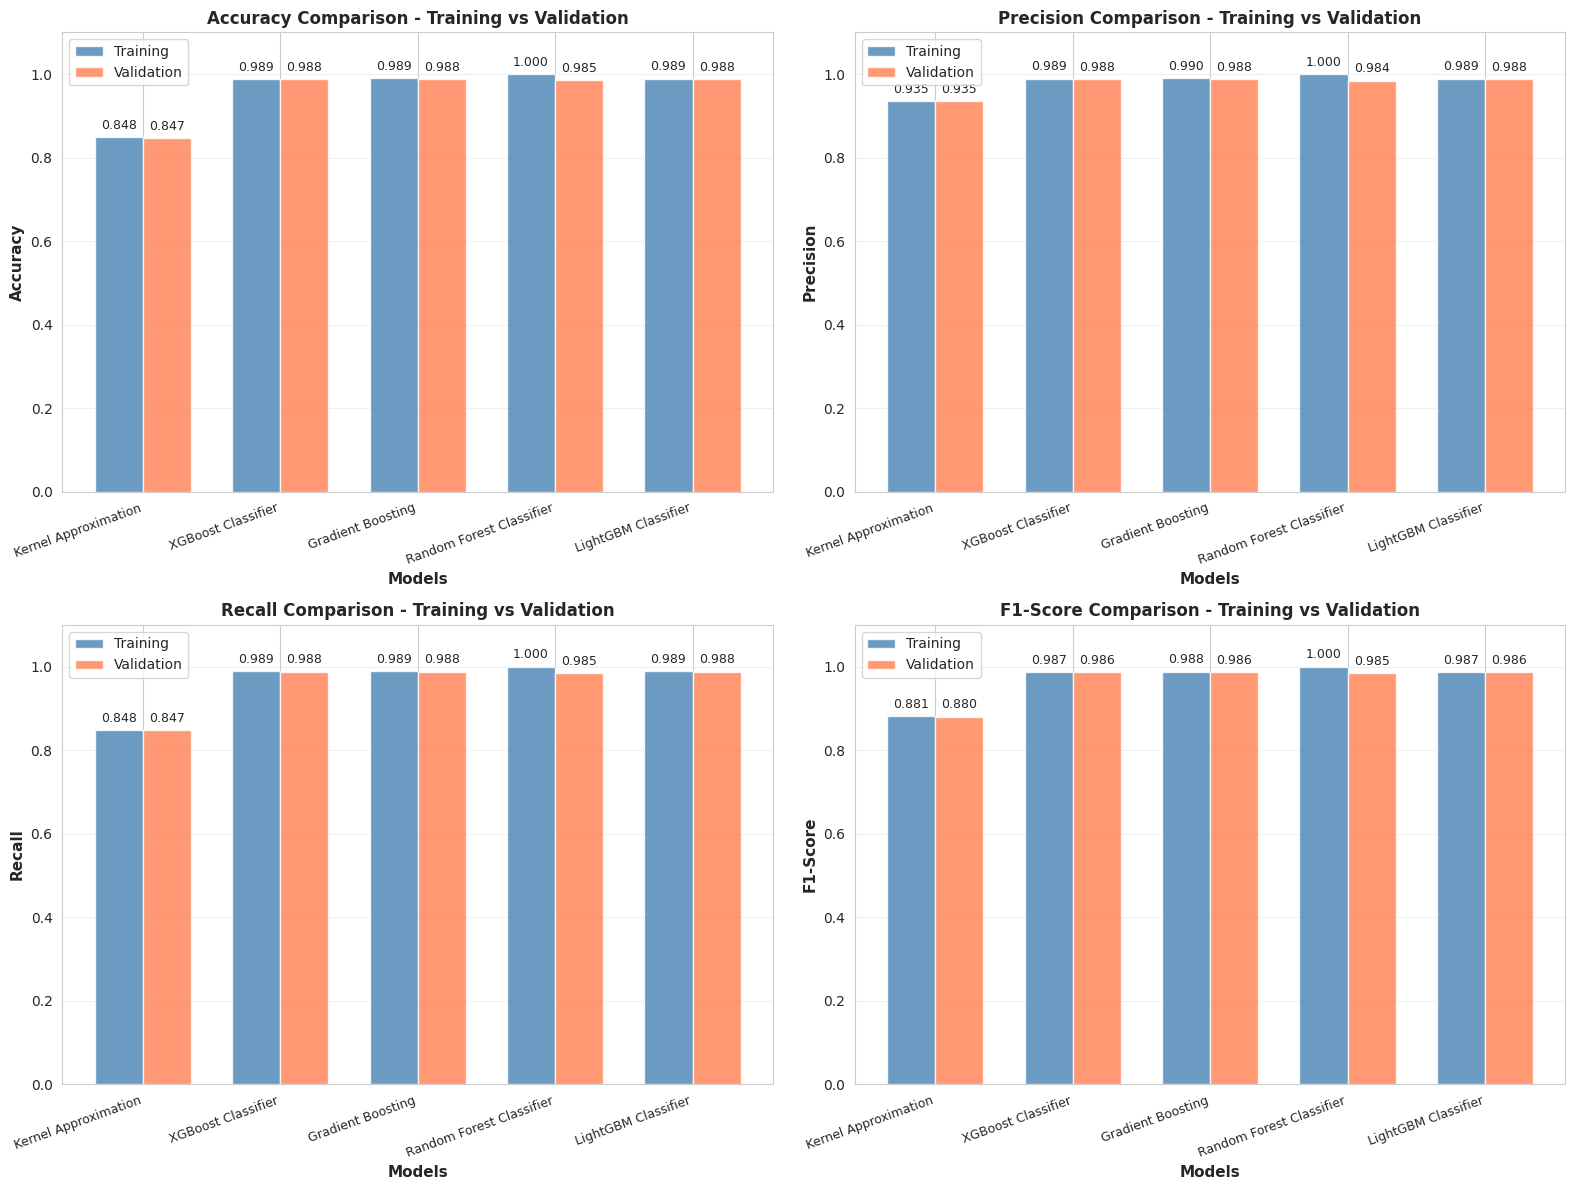

In [18]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]

    model_names = list(models.keys())
    train_scores = [training_results[m][metric] for m in model_names]
    val_scores = [validation_results[m][metric] for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    ax.bar(x - width/2, train_scores, width, label='Training', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, val_scores, width, label='Validation', color='coral', alpha=0.8)

    ax.set_xlabel('Models', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} Comparison - Training vs Validation', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.split('(')[0].strip() for m in model_names], rotation=20, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

    # Add value labels
    for i, (train_val, val_val) in enumerate(zip(train_scores, val_scores)):
        ax.text(i - width/2, train_val + 0.02, f'{train_val:.3f}', ha='center', fontsize=9)
        ax.text(i + width/2, val_val + 0.02, f'{val_val:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# # 8. Save Trained Models


In [19]:
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

# Save each trained model
model_filenames = {
    'Kernel Approximation (RBF + LogisticReg)': 'kernel_approximation_model.pkl',
    'XGBoost Classifier': 'xgboost_model.pkl',
    'Gradient Boosting': 'gradient_boosting_model.pkl',
    'Random Forest Classifier': 'random_forest_model.pkl',
    'LightGBM Classifier': 'lightgbm_model.pkl'
}

for model_name, model_info in trained_models.items():
    filename = model_filenames[model_name]
    joblib.dump({
        'model': model_info['model'],
        'data_type': model_info['data_type']
    }, filename)
    print(f"✓ {model_name} saved as '{filename}'")

# Save the label encoder
joblib.dump(le_target, 'label_encoder_sedra.pkl')
print(f"✓ Label encoder saved as 'label_encoder_sedra.pkl'")


print("\n All models saved successfully!")


SAVING MODELS
✓ Kernel Approximation (RBF + LogisticReg) saved as 'kernel_approximation_model.pkl'
✓ XGBoost Classifier saved as 'xgboost_model.pkl'
✓ Gradient Boosting saved as 'gradient_boosting_model.pkl'
✓ Random Forest Classifier saved as 'random_forest_model.pkl'
✓ LightGBM Classifier saved as 'lightgbm_model.pkl'
✓ Label encoder saved as 'label_encoder_sedra.pkl'

 All models saved successfully!


# # 9. Load Saved Models and Test on Test Data


In [20]:
print("\n" + "="*80)
print("LOADING SAVED MODELS")
print("="*80)

# Load models
loaded_models = {}
for model_name, filename in model_filenames.items():
    loaded_models[model_name] = joblib.load(filename)
    print(f"✓ Loaded {model_name} from '{filename}'")

# Load preprocessing objects
scaler_loaded = joblib.load('robust_scaler.pkl')
selector_loaded = joblib.load('rfe_selector.pkl')
svd_loaded = joblib.load('truncated_svd.pkl')
rbf_sampler_loaded = joblib.load('rbf_sampler.pkl')
le_target_loaded = joblib.load('label_encoder_sedra.pkl')

print("✓ Loaded all preprocessing objects")



LOADING SAVED MODELS
✓ Loaded Kernel Approximation (RBF + LogisticReg) from 'kernel_approximation_model.pkl'
✓ Loaded XGBoost Classifier from 'xgboost_model.pkl'
✓ Loaded Gradient Boosting from 'gradient_boosting_model.pkl'
✓ Loaded Random Forest Classifier from 'random_forest_model.pkl'
✓ Loaded LightGBM Classifier from 'lightgbm_model.pkl'
✓ Loaded all preprocessing objects


# # 10. Test Models on Test Data


In [22]:
print("\n" + "="*80)
print("TESTING MODELS ON TEST DATA")
print("="*80)

test_results = {}

for model_name, model_info in loaded_models.items():
    print(f"\n{'='*60}")
    print(f"Testing: {model_name}")
    print('='*60)

    model = model_info['model']
    data_type = model_info['data_type']

    # Use appropriate features
    if data_type == 'kernel':
        X_te = X_test_kernel
        print("Using: RBF Kernel Features")
        col_prefix = 'rbf'
    else:
        X_te = X_test_svd
        print("Using: SVD Features")
        col_prefix = 'svd'

    # Ensure DataFrame with same column names used during training
    col_names = [f"{col_prefix}_{i}" for i in range(X_te.shape[1])]
    X_te = pd.DataFrame(X_te, columns=col_names)

    # Make predictions
    y_test_pred = model.predict(X_te)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    # Calculate AUC if model supports probability
    try:
        if hasattr(model, 'predict_proba'):
            y_test_proba = model.predict_proba(X_te)[:, 1]
            test_auc = roc_auc_score(y_test, y_test_proba)
        else:
            test_auc = None
    except:
        test_auc = None

    # Store results
    test_results[model_name] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'auc': test_auc,
        'predictions': y_test_pred
    }

    # Print results
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    if test_auc is not None:
        print(f"  ROC-AUC:   {test_auc:.4f}")

    # Print classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred,
                                target_names=le_target_loaded.classes_,

                                zero_division=0))

print("="*80)

print("\n" + "="*80)
print("ALL MODELS TESTED SUCCESSFULLY")


TESTING MODELS ON TEST DATA

Testing: Kernel Approximation (RBF + LogisticReg)
Using: RBF Kernel Features

Test Set Performance:
  Accuracy:  0.8466
  Precision: 0.9347
  Recall:    0.8466
  F1-Score:  0.8793

Detailed Classification Report:
                      precision    recall  f1-score   support

         brute_force       0.86      0.99      0.92      2500
         geo_anomaly       0.17      0.44      0.25      2500
              normal       0.99      0.86      0.92     90005
           port_scan       0.21      0.57      0.31      2500
privilege_escalation       0.40      0.99      0.57      2500

            accuracy                           0.85    100005
           macro avg       0.53      0.77      0.59    100005
        weighted avg       0.93      0.85      0.88    100005


Testing: XGBoost Classifier
Using: SVD Features

Test Set Performance:
  Accuracy:  0.9880
  Precision: 0.9880
  Recall:    0.9880
  F1-Score:  0.9862

Detailed Classification Report:
           

In [23]:
# Create final comparison table
print("\n" + "="*80)
print("FINAL MODEL COMPARISON - TRAIN / VALIDATION / TEST")
print("="*80)

final_comparison = pd.DataFrame({
    'Model': [m.split('(')[0].strip() for m in models.keys()],
    'Train_Acc': [training_results[m]['accuracy'] for m in models.keys()],
    'Val_Acc': [validation_results[m]['accuracy'] for m in models.keys()],
    'Test_Acc': [test_results[m]['accuracy'] for m in models.keys()],
    'Train_F1': [training_results[m]['f1_score'] for m in models.keys()],
    'Val_F1': [validation_results[m]['f1_score'] for m in models.keys()],
    'Test_F1': [test_results[m]['f1_score'] for m in models.keys()],
})

print("\n", final_comparison.to_string(index=False))

# Find best model
best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['f1_score'])
print(f"\n🏆 Best Model (by Test F1-Score): {best_model_name}")
print(f"   Test Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['f1_score']:.4f}")
if test_results[best_model_name]['auc'] is not None:
    print(f"   Test ROC-AUC:  {test_results[best_model_name]['auc']:.4f}")



FINAL MODEL COMPARISON - TRAIN / VALIDATION / TEST

                    Model  Train_Acc  Val_Acc  Test_Acc  Train_F1   Val_F1  Test_F1
    Kernel Approximation   0.848254 0.847185  0.846588  0.880658 0.879710 0.879272
      XGBoost Classifier   0.988571 0.988039  0.987961  0.986950 0.986229 0.986157
       Gradient Boosting   0.989497 0.988019  0.987771  0.988181 0.986406 0.986167
Random Forest Classifier   0.999974 0.984698  0.984361  0.999974 0.984532 0.984295
     LightGBM Classifier   0.988717 0.988139  0.987911  0.987189 0.986411 0.986189

🏆 Best Model (by Test F1-Score): LightGBM Classifier
   Test Accuracy: 0.9879
   Test F1-Score: 0.9862


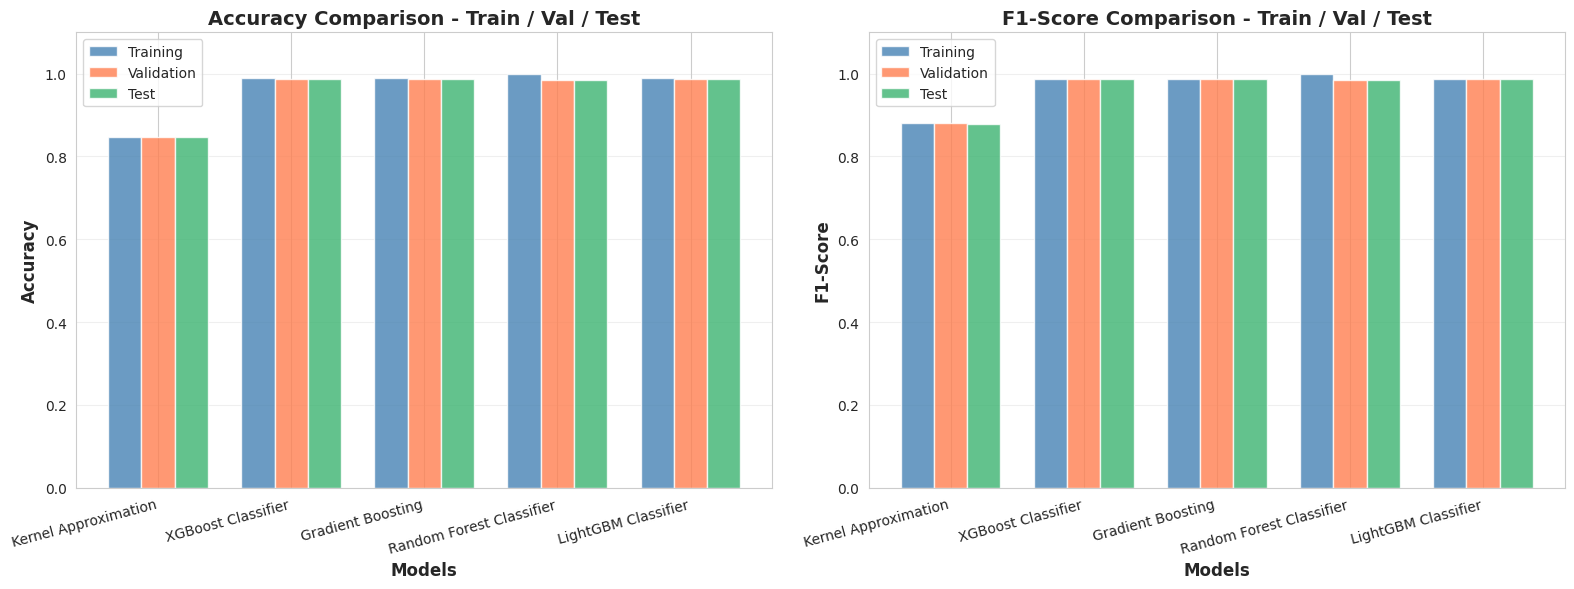

In [24]:
# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax1 = axes[0]
model_names_short = [m.split('(')[0].strip() for m in models.keys()]
train_acc = [training_results[m]['accuracy'] for m in models.keys()]
val_acc = [validation_results[m]['accuracy'] for m in models.keys()]
test_acc = [test_results[m]['accuracy'] for m in models.keys()]

x = np.arange(len(model_names_short))
width = 0.25

ax1.bar(x - width, train_acc, width, label='Training', color='steelblue', alpha=0.8)
ax1.bar(x, val_acc, width, label='Validation', color='coral', alpha=0.8)
ax1.bar(x + width, test_acc, width, label='Test', color='mediumseagreen', alpha=0.8)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison - Train / Val / Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names_short, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# F1-Score comparison
ax2 = axes[1]
train_f1 = [training_results[m]['f1_score'] for m in models.keys()]
val_f1 = [validation_results[m]['f1_score'] for m in models.keys()]
test_f1 = [test_results[m]['f1_score'] for m in models.keys()]

ax2.bar(x - width, train_f1, width, label='Training', color='steelblue', alpha=0.8)
ax2.bar(x, val_f1, width, label='Validation', color='coral', alpha=0.8)
ax2.bar(x + width, test_f1, width, label='Test', color='mediumseagreen', alpha=0.8)

ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison - Train / Val / Test', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names_short, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()


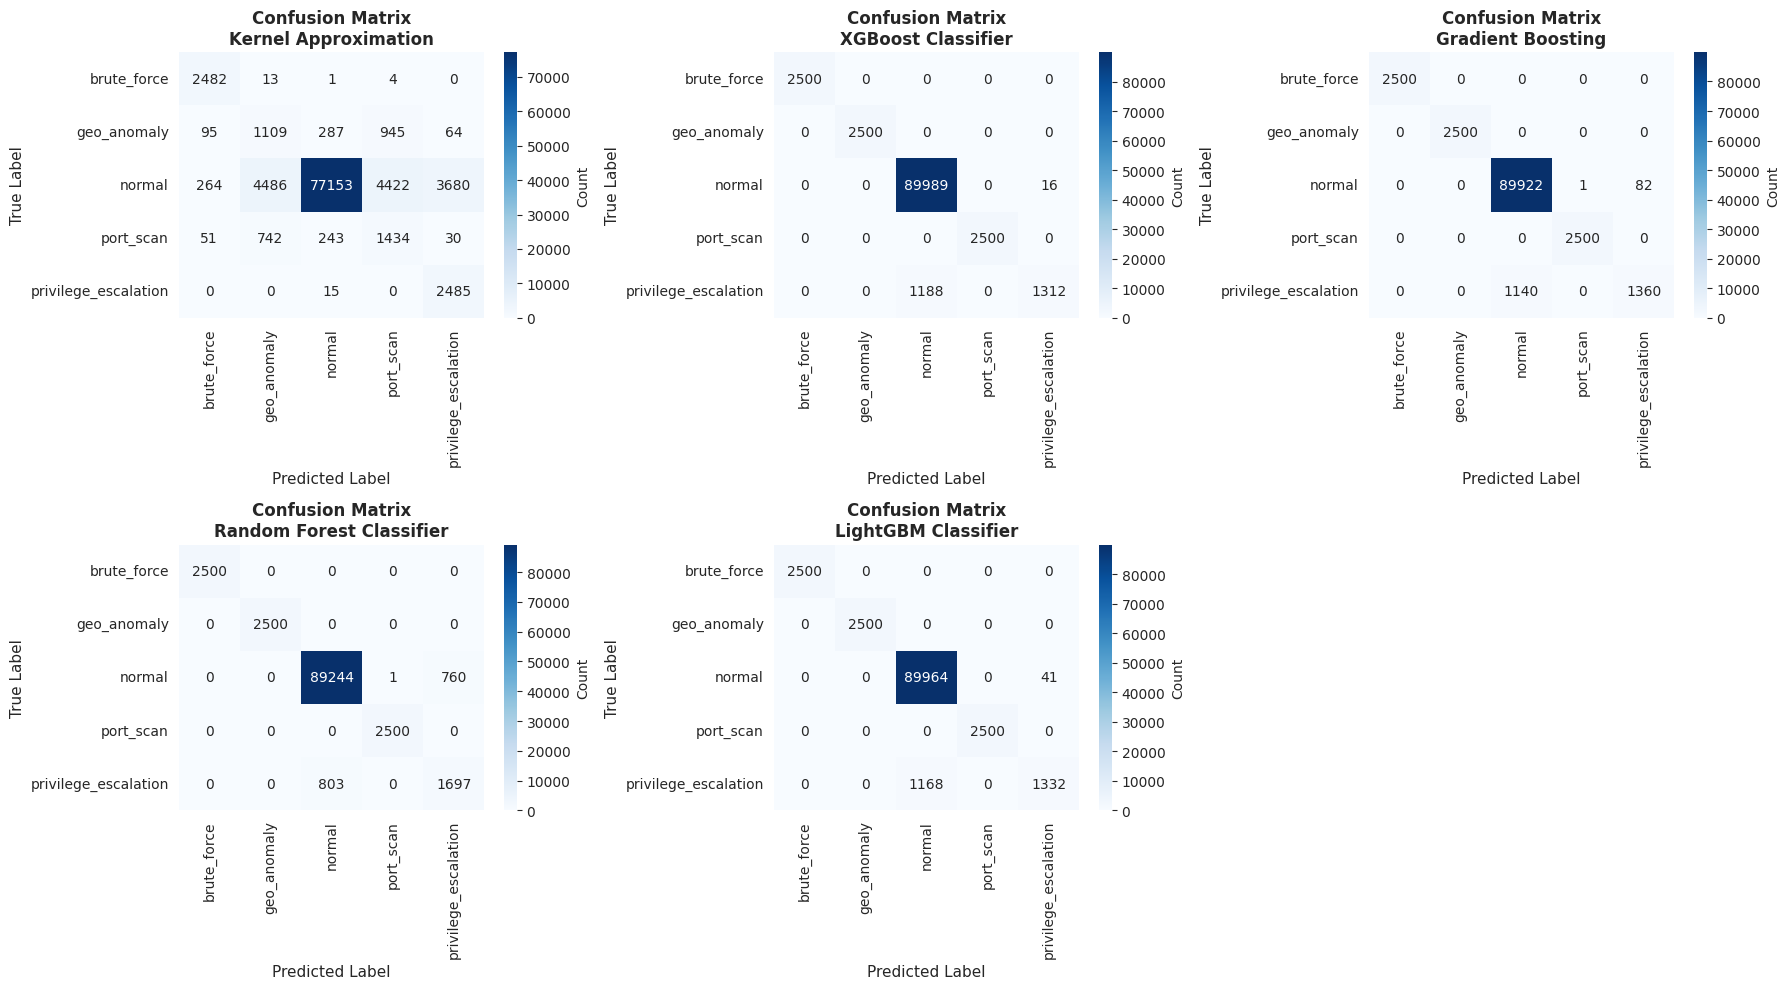

In [25]:
# Confusion matrices for all models
n_models = len(loaded_models)
# Arrange up to 3 columns per row for readability
n_cols = min(3, n_models)
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
# Flatten axes array for easy indexing
axes = np.array(axes).reshape(-1)

for idx, (model_name, model_info) in enumerate(loaded_models.items()):
    ax = axes[idx]
    y_pred = test_results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le_target_loaded.classes_,
                yticklabels=le_target_loaded.classes_,
                cbar_kws={'label': 'Count'})

    model_short = model_name.split('(')[0].strip()
    ax.set_title(f'Confusion Matrix\n{model_short}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)

# Turn off any unused axes
for j in range(len(loaded_models), axes.shape[0]):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# # 11. ROC Curve Analysis



GENERATING ROC CURVES - ONE-VS-REST (OvR) APPROACH
✓ Kernel Approximation: Multiclass (OvR) - Macro AUC = 0.958
  • brute_force: AUC = 1.000
  • geo_anomaly: AUC = 0.911
  • normal: AUC = 0.962
  • port_scan: AUC = 0.938
  • privilege_escalation: AUC = 0.990
✓ XGBoost Classifier: Multiclass (OvR) - Macro AUC = 0.994
  • brute_force: AUC = 1.000
  • geo_anomaly: AUC = 1.000
  • normal: AUC = 0.998
  • port_scan: AUC = 1.000
  • privilege_escalation: AUC = 0.994
✓ Gradient Boosting: Multiclass (OvR) - Macro AUC = 0.994
  • brute_force: AUC = 1.000
  • geo_anomaly: AUC = 1.000
  • normal: AUC = 0.998
  • port_scan: AUC = 1.000
  • privilege_escalation: AUC = 0.994
✓ Random Forest Classifier: Multiclass (OvR) - Macro AUC = 0.987
  • brute_force: AUC = 1.000
  • geo_anomaly: AUC = 1.000
  • normal: AUC = 0.990
  • port_scan: AUC = 1.000
  • privilege_escalation: AUC = 0.962
✓ LightGBM Classifier: Multiclass (OvR) - Macro AUC = 0.994
  • brute_force: AUC = 1.000
  • geo_anomaly: AUC = 1.000

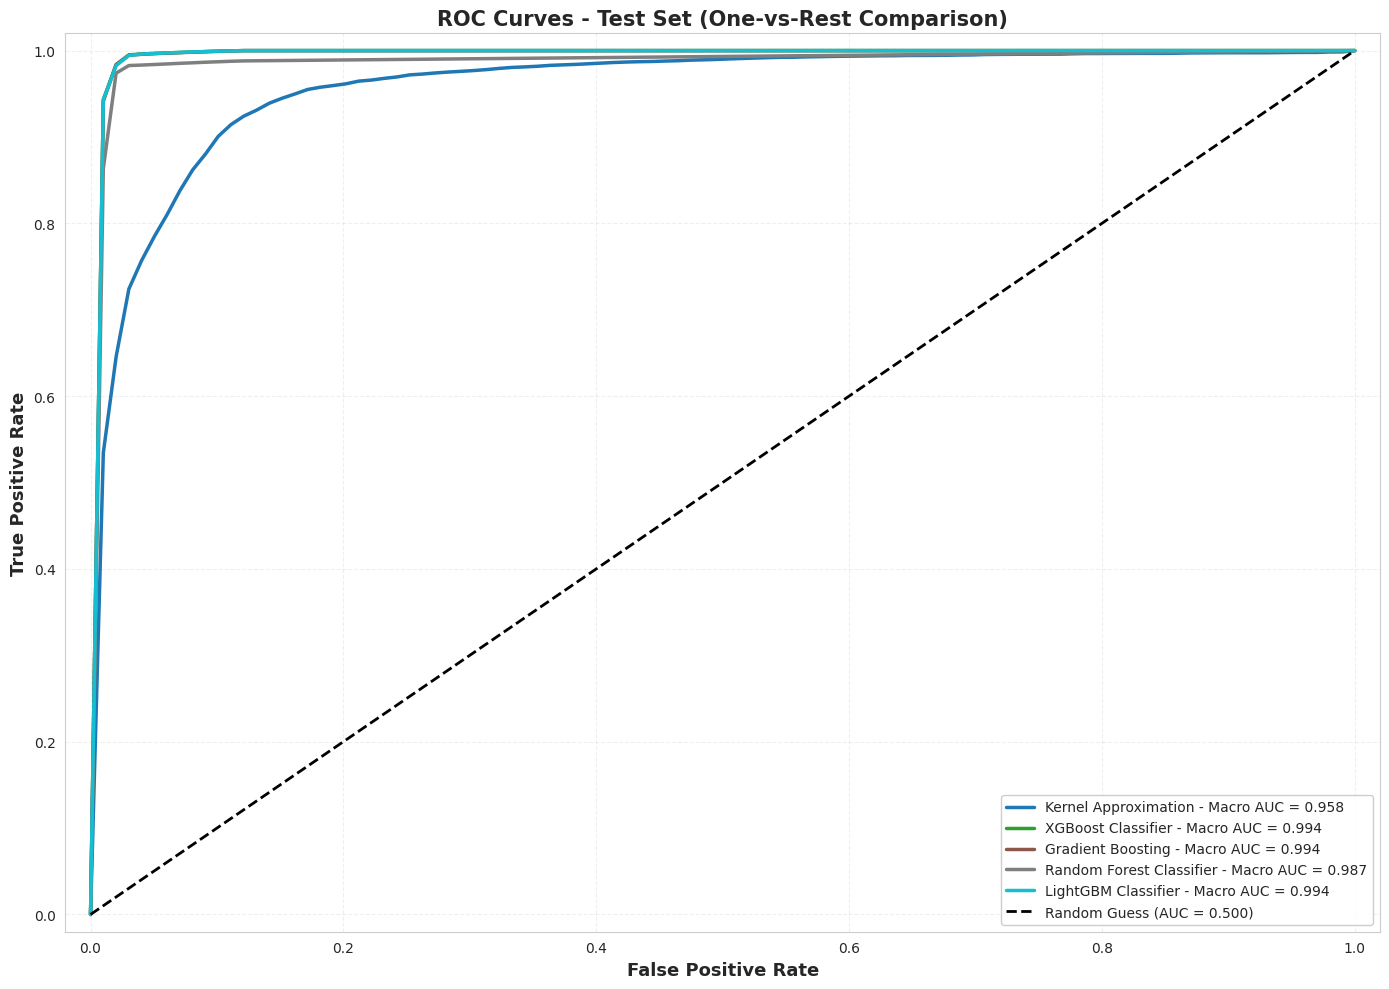


ROC CURVE VISUALIZATION COMPLETED


In [26]:
# ROC Curves for all models - One-vs-Rest (OvR) approach
from sklearn.preprocessing import label_binarize

print("\n" + "="*80)
print("GENERATING ROC CURVES - ONE-VS-REST (OvR) APPROACH")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 10))

# Color palette for models
colors = plt.cm.tab10(np.linspace(0, 1, len(loaded_models)))

for model_idx, (model_name, model_info) in enumerate(loaded_models.items()):
    model = model_info['model']
    data_type = model_info['data_type']

    # Prepare test features using the SAME representation as during training
    if data_type == 'kernel':
        X_te = X_test_kernel
        col_prefix = 'rbf'
    else:
        X_te = X_test_svd
        col_prefix = 'svd'

    # Convert to DataFrame with matching column names used during training
    col_names = [f"{col_prefix}_{i}" for i in range(X_te.shape[1])]
    X_te_df = pd.DataFrame(X_te, columns=col_names)

    model_short = model_name.split('(')[0].strip()
    model_color = colors[model_idx]

    # Check if model supports probability estimates
    if hasattr(model, 'predict_proba'):
        try:
            y_score = model.predict_proba(X_te_df)
        except Exception as e:
            print(f"⚠ {model_short}: Could not get predict_proba - {str(e)}")
            continue

        n_classes = len(le_target_loaded.classes_)
        n_score_cols = y_score.shape[1]

        # ===== BINARY CASE =====
        if n_classes == 2:
            y_proba = y_score[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, linewidth=2.5, color=model_color,
                   label=f'{model_short} (AUC = {roc_auc:.3f})')
            print(f"✓ {model_short}: Binary case - AUC = {roc_auc:.3f}")

        # ===== MULTICLASS CASE (One-vs-Rest) =====
        else:
            # Binarize test labels (shape: n_samples, n_classes)
            classes_to_use = np.arange(n_classes)
            y_test_bin = label_binarize(y_test, classes=classes_to_use)

            # Compute ROC curve and ROC area for each class
            fpr_dict = {}
            tpr_dict = {}
            roc_auc_dict = {}

            for class_idx in range(n_classes):
                fpr_dict[class_idx], tpr_dict[class_idx], _ = roc_curve(
                    y_test_bin[:, class_idx], y_score[:, class_idx]
                )
                roc_auc_dict[class_idx] = auc(fpr_dict[class_idx], tpr_dict[class_idx])

            # Compute macro-averaged ROC curve and AUC
            # Interpolate all ROC curves at this set of fpr points
            mean_fpr = np.linspace(0, 1, 100)
            tpr_interp_list = []

            for class_idx in range(n_classes):
                tpr_interp = np.interp(mean_fpr, fpr_dict[class_idx], tpr_dict[class_idx])
                tpr_interp[0] = 0.0  # Ensure curve starts at (0, 0)
                tpr_interp_list.append(tpr_interp)

            mean_tpr = np.mean(tpr_interp_list, axis=0)
            mean_tpr[-1] = 1.0  # Ensure curve ends at (1, 1)
            macro_roc_auc = auc(mean_fpr, mean_tpr)

            # Plot macro-averaged ROC curve for this model
            ax.plot(mean_fpr, mean_tpr, linewidth=2.5, color=model_color,
                   label=f'{model_short} - Macro AUC = {macro_roc_auc:.3f}')

            print(f"✓ {model_short}: Multiclass (OvR) - Macro AUC = {macro_roc_auc:.3f}")
            for class_idx in range(n_classes):
                print(f"  • {le_target_loaded.classes_[class_idx]}: AUC = {roc_auc_dict[class_idx]:.3f}")

# Add diagonal reference line (Random Guess)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess (AUC = 0.500)')

# Configure plot
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - Test Set (One-vs-Rest Comparison)', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ROC CURVE VISUALIZATION COMPLETED")
print("="*80)



# # 12. Final Summary


In [27]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n📊 Dataset Information:")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Validation samples: {len(X_val)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Original features: {train_data.shape[1] - 1}")
print(f"   - Engineered features: {X_train.shape[1]}")
print(f"   - Selected features (RFE): {X_train_selected.shape[1]}")
print(f"   - SVD components: {X_train_svd.shape[1]}")
print(f"   - Kernel features: {X_train_kernel.shape[1]}")

print("\n🔧 Advanced Preprocessing Pipeline :")
print("   ✓ Feature Engineering:")
print("      - Cyclic encoding (sin/cos) for time features")
print("      - Feature interactions (attempts × port)")
print("      - Frequency encoding for categoricals")
print("      - Port categorization features")
print("   ✓ RobustScaler (instead of StandardScaler)")
print("   ✓ RFE - Recursive Feature Elimination (instead of SelectKBest)")
print(f"   ✓ TruncatedSVD (instead of PCA) - {variance_explained:.2%} variance")
print(f"   ✓ RBF Kernel Approximation ({n_components_kernel} features)")

print("\n🤖 Models Trained:")
for model_name in models.keys():
    print(f"   ✓ {model_name}")

print("\n💾 Saved Files:")
print("   - robust_scaler.pkl")
print("   - rfe_selector.pkl")
print("   - truncated_svd.pkl")
print("   - rbf_sampler.pkl")
print("   - label_encoder_sedra.pkl")
print("   - kernel_approximation_model.pkl")
print("   - xgboost_model.pkl")
print("   - gradient_boosting_model.pkl")
print("   - random_forest_model.pkl")
print("   - lightgbm_model.pkl")

print("\n🏆 Best Performing Model:")
print(f"   Model: {best_model_name}")
print(f"   Test Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   Test Precision: {test_results[best_model_name]['precision']:.4f}")
print(f"   Test Recall: {test_results[best_model_name]['recall']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['f1_score']:.4f}")


print("\n" + "="*80)
print("✅ ADVANCED ML PIPELINE COMPLETED SUCCESSFULLY!")

print("="*80)


FINAL SUMMARY REPORT

📊 Dataset Information:
   - Training samples: 350000
   - Validation samples: 49995
   - Test samples: 100005
   - Original features: 11
   - Engineered features: 24
   - Selected features (RFE): 15
   - SVD components: 12
   - Kernel features: 100

🔧 Advanced Preprocessing Pipeline :
   ✓ Feature Engineering:
      - Cyclic encoding (sin/cos) for time features
      - Feature interactions (attempts × port)
      - Frequency encoding for categoricals
      - Port categorization features
   ✓ RobustScaler (instead of StandardScaler)
   ✓ RFE - Recursive Feature Elimination (instead of SelectKBest)
   ✓ TruncatedSVD (instead of PCA) - 100.00% variance
   ✓ RBF Kernel Approximation (100 features)

🤖 Models Trained:
   ✓ Kernel Approximation (RBF + LogisticReg)
   ✓ XGBoost Classifier
   ✓ Gradient Boosting
   ✓ Random Forest Classifier
   ✓ LightGBM Classifier

💾 Saved Files:
   - robust_scaler.pkl
   - rfe_selector.pkl
   - truncated_svd.pkl
   - rbf_sampler.pkl
  